# 环境库

In [1]:
%pip install akshare --upgrade

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 32.4 MB/s eta 0:00:00
  Created wheel for jsonpath: filename=jsonpath-0.82.2-py3-none-any.whl size=5615 sha256=3e14c88ef36c94367a38f8ef0ae9166787a937596800f8329009332cf7695f74
  Stored in directory: /root/.cache/pip/wheels/7d/b8/16/48bbd715040679311fa68cb564ad24a97d9a67fea5d4c848c8
Successfully built jsonpath


In [1]:
import akshare as ak;
import numpy as np
import pandas as pd

# 数据

In [2]:
from pylab import plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

In [3]:
data = ak.stock_zh_a_minute(symbol='sz300188', period='1')

In [4]:
print(data.tail(10));

                      day    open    high     low   close   volume
1960  2025-08-15 14:49:00  18.790  18.890  18.780  18.850   602413
1961  2025-08-15 14:50:00  18.810  18.850  18.750  18.750   568087
1962  2025-08-15 14:51:00  18.750  18.820  18.730  18.770   554300
1963  2025-08-15 14:52:00  18.790  18.930  18.770  18.920  1008692
1964  2025-08-15 14:53:00  18.930  19.080  18.920  19.070  1002700
1965  2025-08-15 14:54:00  19.070  19.090  18.830  18.830  1386500
1966  2025-08-15 14:55:00  18.830  18.980  18.780  18.950   713812
1967  2025-08-15 14:56:00  18.930  18.960  18.830  18.890   614088
1968  2025-08-15 14:57:00  18.890  18.890  18.770  18.840   856900
1969  2025-08-15 15:00:00  18.850  18.850  18.850  18.850  1238200


In [22]:
data['open'] = data['open'].astype(np.float64);
data['high'] = data['high'].astype(np.float64);
data['low'] = data['low'].astype(np.float64);
data['volume'] = data['volume'].astype(np.int64);
data['day'] = pd.to_datetime(data['day']);

In [11]:
data['close'] = pd.to_numeric(data['close']);
data['r'] = np.log(data['close'] / data['close'].shift(1));
data['d'] = np.sign(data['r']);

# 策略

In [12]:
lags = 3

In [13]:
cols = list()
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['r'].shift(lag)
    cols.append(col)

代码的作用是在 data 这个 DataFrame 中创建滞后的收益率列。

* 首先，它初始化了一个名为 cols 的空列表，用来存储后面创建的列名。
* 然后，它会循环 lags 次（这里 lags 的值是 3）。
* 在每次循环中，它会根据当前的 lag 值创建一个新的列名，例如 'lag_1', 'lag_2', 'lag_3'。
* 接着，它会在 data DataFrame 中创建一个新的列，列名就是刚刚生成的。这一列的值是 'r' 列（收益率列）向下移动 lag 行得到的结果。这样就创建了包含过去收益率值的列。
* 最后，它将新创建的列名添加到 cols 列表中。

这段代码运行后，data DataFrame 中会增加名为 'lag_1', 'lag_2' 和 'lag_3' 的新列，它们分别包含前 1、2 和 3 个时间段的收益率数据。

In [23]:
print(data.head(10));

                   day   open   high    low  close  volume         r  d  \
4  2025-08-05 13:57:00  17.04  17.06  17.03  17.04   86800  0.000000  0   
5  2025-08-05 13:58:00  17.05  17.10  17.05  17.09   99500  0.002930  1   
6  2025-08-05 13:59:00  17.10  17.10  17.09  17.10   24100  0.000585  1   
7  2025-08-05 14:00:00  17.09  17.11  17.08  17.09   37300 -0.000585 -1   
8  2025-08-05 14:01:00  17.09  17.11  17.08  17.11   46800  0.001170  1   
9  2025-08-05 14:02:00  17.11  17.11  17.08  17.10   68800 -0.000585 -1   
10 2025-08-05 14:03:00  17.10  17.11  17.10  17.11   31500  0.000585  1   
11 2025-08-05 14:04:00  17.11  17.13  17.10  17.11   69300  0.000000  0   
12 2025-08-05 14:05:00  17.11  17.12  17.11  17.11   47500  0.000000  0   
13 2025-08-05 14:06:00  17.11  17.12  17.11  17.11   25600  0.000000  0   

       lag_1     lag_2     lag_3  
4  -0.001759 -0.001171 -0.001170  
5   0.000000 -0.001759 -0.001171  
6   0.002930  0.000000 -0.001759  
7   0.000585  0.002930  0.000000  

In [15]:
data.dropna(inplace=True); #删除 DataFrame 中所有包含缺失值（NaN）的行

In [16]:
data['d'] = data['d'].astype(int); #将 data DataFrame 中 'd' 列的数据类型转换为整数

# 拆分出训练数据和验证数据

In [17]:
split = int(len(data) * 0.8); #计算用于将数据集分割成训练集和测试集的索引位置

In [18]:
print(split);

1572


将数据分割成 80% 的训练集和 20% 的测试集

## 准备训练数据

In [19]:
train = data.iloc[:split].copy(); #从第一行开始，split 表示到 split 索引（不包含该行）为止,复制一份到训练中

In [21]:
mu, std = train.drop('day', axis=1).mean(), train.drop('day', axis=1).std(); #计算得出两数组

* mean() 平均值
* std() 标准差，衡量数据的离散程度。

计算训练集的均值和标准差通常是数据预处理的一个重要步骤，特别是当您需要对数据进行标准化（Standardization）或归一化（Normalization）时。

使用训练集的统计信息来转换训练集和测试集可以避免数据泄露（Data Leakage），即测试集的信息“泄露”到训练过程中。

In [28]:
print(train.head(10));

                    day   open   high    low  close  volume         r  d  \
4   2025-08-05 13:57:00  17.04  17.06  17.03  17.04   86800  0.000000  0   
5   2025-08-05 13:58:00  17.05  17.10  17.05  17.09   99500  0.002930  1   
6   2025-08-05 13:59:00  17.10  17.10  17.09  17.10   24100  0.000585  1   
7   2025-08-05 14:00:00  17.09  17.11  17.08  17.09   37300 -0.000585 -1   
8   2025-08-05 14:01:00  17.09  17.11  17.08  17.11   46800  0.001170  1   
9   2025-08-05 14:02:00  17.11  17.11  17.08  17.10   68800 -0.000585 -1   
10  2025-08-05 14:03:00  17.10  17.11  17.10  17.11   31500  0.000585  1   
11  2025-08-05 14:04:00  17.11  17.13  17.10  17.11   69300  0.000000  0   
12  2025-08-05 14:05:00  17.11  17.12  17.11  17.11   47500  0.000000  0   
13  2025-08-05 14:06:00  17.11  17.12  17.11  17.11   25600  0.000000  0   

       lag_1     lag_2     lag_3  
4  -0.001759 -0.001171 -0.001170  
5   0.000000 -0.001759 -0.001171  
6   0.002930  0.000000 -0.001759  
7   0.000585  0.002930 

In [ ]:
print(mu);
print(std);

In [26]:
train_ = (train - mu) / std;

In [27]:
print(train_);

         close         d  day      high     lag_1     lag_2     lag_3  \
4     0.703336  0.041636  NaN  0.696466 -0.684956 -0.466246 -0.465020   
5     0.771337  1.210431  NaN  0.750131 -0.030409 -0.685077 -0.465530   
6     0.784937  1.210431  NaN  0.750131  1.059864 -0.030499 -0.684384   
7     0.771337 -1.127158  NaN  0.763547  0.187262  1.059825 -0.029738   
8     0.798537  1.210431  NaN  0.763547 -0.248081  0.187183  1.060700   
...        ...       ...  ...       ...       ...       ...       ...   
1571  4.048952 -1.127158  NaN  4.292056 -6.050519 -0.030499 -0.029738   
1572  3.912952 -1.127158  NaN  4.077394 -2.313299 -6.050894 -0.029738   
1573  3.967352  1.210431  NaN  4.050561 -1.943575 -2.313497 -6.050757   
1574  3.926552 -1.127158  NaN  3.916397  0.736038 -1.943755 -2.312973   
1575  4.212153  1.210431  NaN  4.131059 -0.605097  0.735984 -1.943192   

           low      open         r    volume  
4     0.731622  0.710631 -0.033212 -0.218040  
5     0.759384  0.724319  1.0

## 准备验证数据

In [31]:
test = data.iloc[split:].copy(); #%20的测试数据
test_ = (test.drop('day', axis=1) - mu) / std

# 训练

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

* MLPClassifier 是用于分类任务的多层感知器（Multilayer Perceptron）模型，也就是一种神经网络模型。
* accuracy_score 是一个评估分类模型性能的指标，它计算模型预测的准确率，即正确预测的样本占总样本数的比例。

In [33]:
model = MLPClassifier(hidden_layer_sizes=[24],
                      shuffle=False,
                      max_iter=500)

* model = MLPClassifier(...): 创建一个 MLPClassifier 对象，并将其赋值给变量 model。
* hidden_layer_sizes=[24]: 这个参数指定了神经网络中隐藏层的结构。[24] 表示模型有一个隐藏层，这个隐藏层有 24 个神经元。您可以根据需要调整隐藏层的数量和每个隐藏层的神经元数量。
* shuffle=False: 这个参数控制在每次迭代训练时是否打乱训练数据的顺序。在这里设置为 False 意味着数据将按照原始顺序进行训练。在时间序列数据中，通常不打乱数据顺序，以保留时间上的依赖性。
* max_iter=500: 这个参数指定了模型训练的最大迭代次数（epochs）。模型会在最多进行 500 次完整的训练数据遍历后停止训练。如果模型在达到最大迭代次数之前收敛（损失函数不再显著下降），训练也会提前停止。

总的来说，这段代码创建了一个具有一个包含 24 个神经元的隐藏层的神经网络模型，并设置了训练时数据不打乱以及最大迭代次数为 500。这个 model 对象将在后续步骤中用于训练和预测。

In [34]:
model.fit(train_[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[24], max_iter=500, shuffle=False)

使用训练数据来训练之前创建的神经网络模型。

* .fit(...): 这是机器学习模型对象的标准方法，用于使用提供的数据来训练模型。
* train_[cols]: 这是训练模型的特征数据。
  * 等价于 train_[['lag_1', 'lag_2', 'lag_3']];
  * train_ 是经过标准化的训练集 DataFrame。
  * [cols] 使用之前定义的 cols 列表（包含 'lag_1', 'lag_2', 'lag_3'）来选择 train_ DataFrame 中作为模型输入的特征列。
* train['d']: 这是训练模型的标签或目标变量。
  * train 是原始的训练集 DataFrame。
  * ['d'] 选择了 'd' 列，它包含了您想要模型预测的目标值（在这里是收益率的方向，1 或 -1）。

简而言之,告诉模型使用 train_ DataFrame 中滞后收益率列的数据 (train_[cols]) 作为输入特征，

并使用 train DataFrame 中的 'd' 列数据 (train['d']) 作为对应的目标输出来学习如何进行分类。

模型会根据这些数据调整其内部参数，以便能够对新的、未见过的数据进行预测。  

In [35]:
score = accuracy_score(train['d'], model.predict(train_[cols]));
print(score);

0.4064885496183206


计算训练集上模型预测的准确率。
* accuracy_score(...): 这是您之前导入的用于计算准确率的函数。它需要两个参数：真实标签和模型预测的标签。
* train['d']: 这是训练集的真实标签，也就是 train DataFrame 中的 'd' 列。
* model.predict(train_[cols]): 这部分代码使用训练好的 model 对训练数据 train_[cols] 进行预测。model.predict() 方法会返回模型预测的标签。

所以，accuracy_score() 函数会将训练集的真实标签 (train['d']) 与模型在训练集上预测的标签 (model.predict(train_[cols])) 进行比较，然后计算并返回准确率。

这个准确率告诉您模型在它已经“见过”的数据上表现如何。

通常，训练集上的准确率会比较高，但这并不能完全代表模型在新的、未见过的数据上的表现。

为了评估模型的泛化能力，您还需要计算在测试集上的准确率。

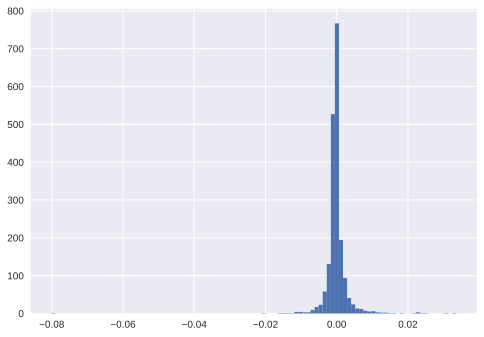

In [36]:
data['r'].hist(bins=100);

绘制收益率 'r' 列的直方图。

* data['r']: 选择了 data DataFrame 中的 'r' 列，也就是计算出的收益率数据。
    .hist(bins=100): 这是 pandas Series 的一个方法，用于绘制直方图。
* bins=100 参数指定了直方图的 bin（柱子）的数量。设置 bins=100 会将收益率数据的范围分成 100 个区间，然后统计每个区间内的数据点数量。

这段代码会生成一个直方图，显示收益率 'r' 的分布情况。
可以从直方图中看出收益率主要集中在哪些范围内，以及它们的分布形状（例如是否接近正态分布）。